In [1]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
train_df = pd.read_parquet("data/train_v5.parquet")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Columns: 295 entries, id to kfold
dtypes: float32(292), float64(1), int32(2)
memory usage: 846.9 MB


In [4]:
train_df

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Sex_Encoded,BMI,...,Mult_1_1_Training_Load_VO2,Mult_1_-1_Training_Load_VO2,Mult_-1_1_Training_Load_VO2,Mult_1_1_Training_Load_Heat_Index,Mult_1_-1_Training_Load_Heat_Index,Mult_-1_1_Training_Load_Heat_Index,Mult_1_1_VO2_Heat_Index,Mult_1_-1_VO2_Heat_Index,Mult_-1_1_VO2_Heat_Index,kfold
0,0,36.0,189.0,82.0,26.0,101.0,41.000000,150.0,1.0,22.955685,...,730.056519,0.278996,3.584286,1484.260864,0.137228,7.287129,5320.016113,0.491865,2.033077,4
1,1,64.0,163.0,60.0,8.0,85.0,39.700001,34.0,-1.0,22.582708,...,196.441544,0.096724,10.338671,94.153847,0.201804,4.955294,973.425659,2.086389,0.479297,0
2,2,51.0,161.0,64.0,7.0,84.0,39.799999,29.0,-1.0,24.690405,...,155.781723,0.077708,12.868717,68.194084,0.177515,5.633334,877.570374,2.284388,0.437754,3
3,3,20.0,192.0,90.0,25.0,105.0,40.700001,140.0,1.0,24.414062,...,692.081238,0.248910,4.017524,1214.062500,0.141892,7.047619,4877.524902,0.570054,1.754220,2
4,4,38.0,166.0,61.0,25.0,102.0,40.599998,146.0,-1.0,22.136740,...,721.734070,0.271995,3.676543,1260.989014,0.155678,6.423529,4636.080078,0.572356,1.747166,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,28.0,193.0,97.0,30.0,114.0,40.900002,230.0,1.0,26.040968,...,997.713745,0.318012,3.144533,2084.062500,0.152244,6.568421,6553.404297,0.478735,2.088838,1
749996,749996,64.0,165.0,63.0,18.0,92.0,40.500000,96.0,-1.0,23.140495,...,505.886780,0.222750,4.489333,668.769287,0.168498,5.934782,3002.327881,0.756444,1.321974,4
749997,749997,60.0,162.0,67.0,29.0,113.0,40.900002,221.0,1.0,25.529644,...,1135.685425,0.369364,2.707354,2316.429443,0.181090,5.522124,6271.395020,0.490274,2.039675,0
749998,749998,45.0,182.0,91.0,17.0,102.0,40.299999,109.0,1.0,27.472527,...,509.994171,0.192512,5.194493,555.870850,0.176623,5.661765,2887.467041,0.917469,1.089955,2


In [5]:
metadata_cols = ["id", "kfold"]
target_col = "Calories"
feature_cols = [col for col in train_df.columns if col not in metadata_cols + [target_col]]
X = train_df[feature_cols]
y = train_df[target_col]
y

0         150.0
1          34.0
2          29.0
3         140.0
4         146.0
          ...  
749995    230.0
749996     96.0
749997    221.0
749998    109.0
749999    103.0
Name: Calories, Length: 750000, dtype: float64

In [6]:
def compute_mi(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    """
    Computes mutual information between each feature in X and target y,
    with a progress bar.
    """
    mi_scores = []
    for col in tqdm(X.columns, desc="Computing Mutual Information"):
        mi = mutual_info_regression(X[[col]], y, discrete_features='auto', random_state=42)
        mi_scores.append(mi[0])
    
    return pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

In [7]:
X_sampled = X.sample(n=10000, random_state=42)
y_sampled = y.loc[X_sampled.index]
mi_series = compute_mi(X_sampled, y_sampled)
mi_series

Computing Mutual Information: 100%|██████████| 292/292 [00:06<00:00, 45.49it/s]


Mult_1_1_Total_Exertion_pct_MHR        2.456301
Mult_1_1_Training_Load_VO2             2.423335
Mult_1_-1_Sex_Encoded_Training_Load    2.354798
Mult_-1_1_Sex_Encoded_Training_Load    2.347495
Mult_1_1_Sex_Encoded_Training_Load     2.347495
                                         ...   
Mult_1_1_BMI_MHR                       0.017236
Mult_1_-1_Body_Fat_Pct_MHR             0.016245
Mult_-1_1_Body_Fat_Pct_MHR             0.014697
Sex_Encoded                            0.012043
Mult_1_1_BMR_MHR                       0.009322
Length: 292, dtype: float64

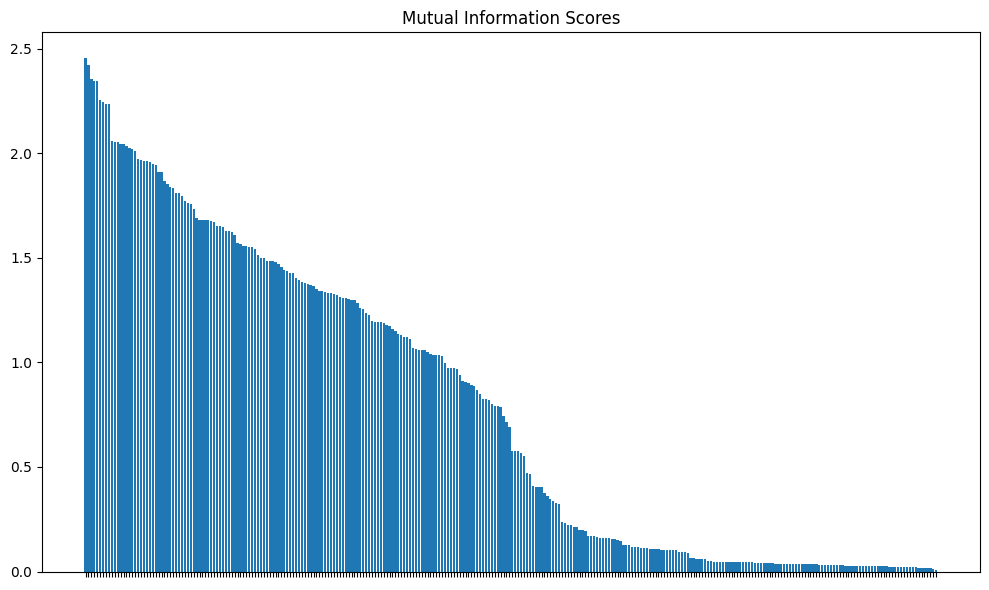

In [8]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.bar(mi_series.index, mi_series.values)
ax.set_xticklabels([])
ax.set_title("Mutual Information Scores")
plt.tight_layout()
plt.show()

In [11]:
mi_series[:20]

TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_mean                        2.776377
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_median                      2.743680
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_q75                         2.720322
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_q25                         2.696700
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_Rounded_Body_Temp_mean      2.678022
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_Rounded_Body_Temp_median    2.655427
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_Rounded_Body_Temp_q75       2.625626
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_Rounded_Body_Temp_q25       2.598341
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_max                         2.576306
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_Rounded_Body_Temp_max       2.493564
TE_Sex_Age_Rounded_Duration_Rounded_Heart_Rate_min                         2.441422
TE_Age_Rounded_Duration_Rounded_Heart_Rate_mean                            2

In [12]:
mi_series[-50:]

TE_Rounded_BMI_Rounded_Body_Temp_q75            0.771604
TE_Sex_Rounded_Body_Temp_min                    0.730423
TE_Sex_Age_Rounded_Body_Temp_min                0.729661
TE_Age_Rounded_Body_Temp_max                    0.729158
TE_Age_Rounded_Body_Temp_min                    0.722888
TE_Rounded_BMI_Rounded_Body_Temp_min            0.703297
TE_Age_Rounded_BMI_Rounded_Body_Temp_min        0.701532
TE_Sex_Age_Rounded_BMI_Rounded_Body_Temp_min    0.695036
TE_Sex_Age_Rounded_Body_Temp_max                0.684526
TE_Sex_Rounded_BMI_Rounded_Body_Temp_min        0.676307
pct_MHR                                         0.665325
TE_Age_Rounded_BMI_Rounded_Body_Temp_max        0.650143
TE_Sex_Age_Rounded_BMI_Rounded_Body_Temp_max    0.639672
TE_Sex_Rounded_BMI_Rounded_Body_Temp_max        0.615342
TE_Rounded_BMI_Rounded_Body_Temp_max            0.554268
TE_Sex_Rounded_Body_Temp_max                    0.534348
TE_Sex_Age_mean                                 0.115405
MHR                            

In [13]:
whitelist_features = [
    "Sex_Encoded", 
    "Age", 
    "Height", 
    "Weight", 
    "Duration", 
    "Heart_Rate",
    "Body_Temp",
    "BMI",
    "Total_Exertion",
    "Heart_Effort",
    "BMR",
    "LBM",
    "BSA",
    "Body_Fat_Pct",
    "MHR",
    "pct_MHR",
    "Training_Load",
    "VO2",
    "Heat_Index",
]

# Exclude original features from the low MI features
top_k = 10
low_mi_features = [col for col in mi_series.index[top_k:] if col not in whitelist_features]
len(low_mi_features)

316

In [14]:
train_df.drop(columns=low_mi_features, inplace=True)
test_df = pd.read_parquet("data/test_v2.parquet")
test_df.drop(columns=low_mi_features, inplace=True)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 42 columns):
 #   Column                                                                   Non-Null Count   Dtype  
---  ------                                                                   --------------   -----  
 0   id                                                                       750000 non-null  int32  
 1   Age                                                                      750000 non-null  float32
 2   Height                                                                   750000 non-null  float32
 3   Weight                                                                   750000 non-null  float32
 4   Duration                                                                 750000 non-null  float32
 5   Heart_Rate                                                               750000 non-null  float32
 6   Body_Temp                                                   

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 40 columns):
 #   Column                                                                   Non-Null Count   Dtype  
---  ------                                                                   --------------   -----  
 0   id                                                                       250000 non-null  int32  
 1   Age                                                                      250000 non-null  float32
 2   Height                                                                   250000 non-null  float32
 3   Weight                                                                   250000 non-null  float32
 4   Duration                                                                 250000 non-null  float32
 5   Heart_Rate                                                               250000 non-null  float32
 6   Body_Temp                                                   

In [17]:
train_df.to_parquet("data/train_v3.parquet", index=False)
test_df.to_parquet("data/test_v3.parquet", index=False)